# Problem Set 3 (First Model Runs)

## MACS 31300: AI Applications in Social Sciences

### Mingtao Gao and Ishan Nagpal

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

#### Data Cleaning and Spliting

In [4]:
def df_clean():   
    path = '/Users/ivnagpal/Desktop/Enron Final Project/MACS31300_Final_Project'
    os.chdir(path)
    df = pd.read_csv (r'enron.csv')
    df = df.drop(columns=['email_address','position']) 
    df = df.fillna(df.mean())
    return df
    
df = df_clean()

#Freatures
x = df.drop (columns = ['insider','POI'])

#Labels
y = df[['POI']]

We drop the columns containing insider's email addreses, names, and position in Enron because they are not to our POI predicting model. Further, we replace the missing values for the retained features with its mean. We split the dataframe into a dataframe containing features and POI.

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state= 40)
print ('Number of training samples:', len (x_train), 'Observations')
print ('Number of test samples:', len (x_test), 'Observations')

Number of training samples: 100 Observations
Number of test samples: 44 Observations


70% and 30% of the 144 observation are randomly placed in training and testing dataframes respectively for modeling.

In [6]:
bag = BaggingClassifier(DecisionTreeClassifier(max_depth =4),n_estimators = 50, oob_score= True,random_state = 40)
bag.fit(x_train,y_train)
decision_function = bag.oob_decision_function_
print ('\nTraining Data Accuracy Score:', bag.score(x_train, y_train))
print ("Decision Function Array:\n", decision_function)


Training Data Accuracy Score: 0.98
Decision Function Array:
 [[0.09034792 0.90965208]
 [0.99462508 0.00537492]
 [0.41787633 0.58212367]
 [0.64945471 0.35054529]
 [0.97467373 0.02532627]
 [0.13966451 0.86033549]
 [0.93404393 0.06595607]
 [0.99254527 0.00745473]
 [0.99452279 0.00547721]
 [0.9940365  0.0059635 ]
 [0.99439332 0.00560668]
 [0.99525277 0.00474723]
 [0.17391304 0.82608696]
 [0.97622818 0.02377182]
 [0.98261271 0.01738729]
 [0.81717378 0.18282622]
 [0.9914394  0.0085606 ]
 [0.80548757 0.19451243]
 [0.98679449 0.01320551]
 [0.9938922  0.0061078 ]
 [0.99090909 0.00909091]
 [0.99167081 0.00832919]
 [0.99394317 0.00605683]
 [0.51170931 0.48829069]
 [0.96519216 0.03480784]
 [0.99526101 0.00473899]
 [0.99578581 0.00421419]
 [0.99163967 0.00836033]
 [0.99610008 0.00389992]
 [0.99013955 0.00986045]
 [0.92486525 0.07513475]
 [0.93016105 0.06983895]
 [0.6239297  0.3760703 ]
 [0.90139527 0.09860473]
 [0.97099311 0.02900689]
 [0.95423394 0.04576606]
 [0.99536534 0.00463466]
 [0.15656566 

Our bagging tree classifier takes bootstrapped samples of the test data to generate 50 decision trees. It then determines whether the observation is a "POI" based on the most popular outcome when running the attributes through all randomly generated decision trees. We obtain a Training Data Accuracy score of 0.98 suggesting overfitting, which could result in a low accuracy score when we run the test data through the model. Previewed above is our model's decision function array. For each observation, when the value in the first column is larger than the second, the bagging tree classifies the observation as not a POI. Conversely, when the observation in the second column is larger than the first, the bagging tree classifies the observation as a POI.

#### Predict Labels of Test Data using Bagging Tree Classifier

In [7]:
y_bagp = bag.predict(x_test)
y_prob = bag.predict_proba(x_test)
print ('First 10 Test Prediction Values:\n', y_bagp[0:10])
print ('\nFirst 10 Test Probability Values:\n', y_prob[0:10])

First 10 Test Prediction Values:
 ['No' 'No' 'No' 'Yes' 'No' 'No' 'No' 'No' 'No' 'Yes']

First 10 Test Probability Values:
 [[0.99442541 0.00557459]
 [0.99442541 0.00557459]
 [0.76180898 0.23819102]
 [0.48302703 0.51697297]
 [0.99442541 0.00557459]
 [0.89428301 0.10571699]
 [0.92989365 0.07010635]
 [0.99442541 0.00557459]
 [0.99442541 0.00557459]
 [0.42202147 0.57797853]]


We run the the test data frame through the bagging tree classifier (50 Random generated trees) to obtain "POI" predictions. We print the first 10 predictions, where a "No" value indicates that the insider is not a POI, and vice versa. We also print the Probability estimates, which highlight the results of each observation when they are run through the random forest. When the probability value in the second column is greater than the first, the model labels the observation as a POI and vice versa.

#### Accuracy Metrics

In [8]:
#Accuracy Score
print("Accuracy:", round (metrics.accuracy_score(y_test, y_bagp),4))

#Confusion Matrix
print('\nConfusion Matrix:\n',confusion_matrix(y_test, y_bagp))

Accuracy: 0.7955

Confusion Matrix:
 [[33  4]
 [ 5  2]]


We find that the bagging tree classifier accurately predicts the correct POI/non-POI label 79.95% of the time (35/44). The confusion matrix suggests that the model predicted 33 out of 38 non-POI observations (86.84%) and 2 out 7 POI observations (28.57%), with a precision score of 33.6%. We are troubled with the model's type 1 and type II error rate. It does not appear to do an effective job predicting POI. 







####  Feature Importance Plot

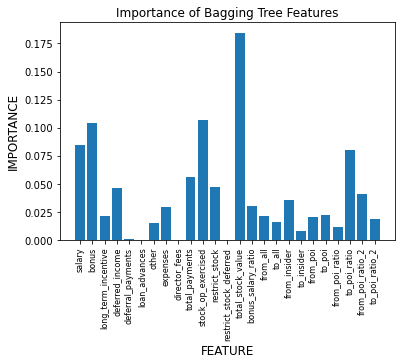

In [9]:
importance = np.mean([tree.feature_importances_ for tree in bag.estimators_], axis=0)
df_imp = pd.DataFrame(data=importance,index= list (x_train.columns), columns=['Importance'])
df_imp = df_imp.reset_index()
plt.bar (df_imp['index'],df_imp['Importance'])
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel('FEATURE',fontsize = 12)
plt.ylabel('IMPORTANCE',fontsize = 12)
plt.title('Importance of Bagging Tree Features')
plt.show()

The graph suggests that the model predomimately relied upon the insider's stock valuation prior to bankruptcy, annual bonus and salary, and stock options exercised in detecting POIs. Conversely, the model did not relay on insider's defferall payments, loan advancesm and restricted stocks deferred in its predictions. 

In [11]:
#Train Bagging Tree Model with CV of 10
tree_cv_scores = cross_val_score(bag, x_train, y_train, cv=50)

print('Simple Decision Tree cv_scores mean:{}'.format(np.mean(tree_cv_scores))) 

Simple Decision Tree cv_scores mean:0.83
